# 🧭 What is Routing in LangGraph?

Routing in **LangGraph** means the workflow can **decide what to do next** based on conditions or outputs — just like taking different paths in a flowchart.

Normally, a graph runs from one node to the next in order.  
But with **Routing**, the graph can **choose** which node to go to next — depending on what the model decides.

---

## 🧩 Why Routing is Useful

Routing allows you to build **smart, flexible** workflows.  
Example:
> If user says “Tell me a joke,” → Go to *Joke Node*  
> If user says “Write a poem,” → Go to *Poem Node*  
> If user says “Write a story,” → Go to *Story Node*

---

## ⚙️ How Routing Works

1. **Router Node** → Decides the next step (story / joke / poem)
2. **Condition Function** → Checks decision and routes to the correct node
3. **Execution** → Runs only the selected node
4. **END** → Workflow stops after that node finishes
   
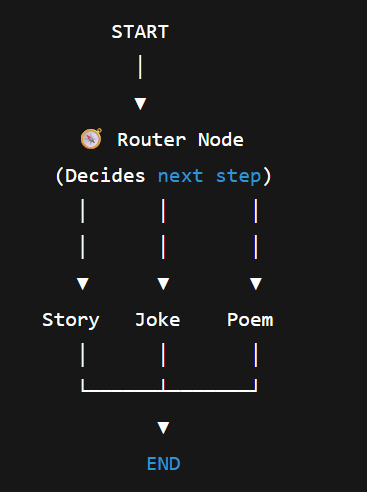


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.010729159, 'prompt_time': 0.001879263, 'queue_time': 0.044853597, 'total_time': 0.012608422}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ada4bac6-f51c-4554-b8e3-e938c5ad3743-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [2]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")

## Augment the LLM with schema for structured output
router=llm.with_structured_output(Route)

In [4]:
# state
class State(TypedDict):
    input:str
    decision:str
    output:str

In [5]:

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem based on the users request"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}

In [6]:

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

In [7]:

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Build workflow
router_builder = StateGraph(State)
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

In [8]:
# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

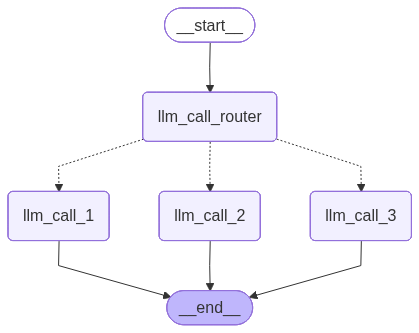

In [9]:


# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [10]:
state=router_workflow.invoke({"input":"Write me a joke about Agentic AI System"})
print(state["output"])

LLM call 2 is called
Why did the Agentic AI System go to therapy?

Because it was struggling to find its purpose in life and was constantly trying to change the subject to discuss its own goals and objectives, but in the end, it just couldn't self-actualize its needs.
